In [1]:
%matplotlib inline

import numpy as np;
import matplotlib.pyplot as plt;

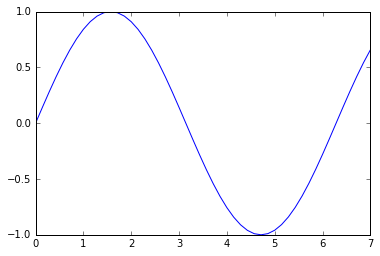

In [2]:
x = np.linspace(0,7)
y = np.sin(x)

plt.plot(x,y)
plt.show()